# Estimating titanic survival rate with logistic regression

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [31]:
titanic = pd.read_csv('data/titanic.csv')

In [32]:
titanic.head()

,Passengerid,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S
1,2,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S
2,3,0,1,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S
3,4,0,1,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S
4,5,0,1,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S


In [33]:
titanic.describe()

,Passengerid,Survived,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,655.000000,0.381971,2.294882,29.881135,0.498854,0.385027,33.295479
std,378.020061,0.486055,0.837836,14.413500,1.041658,0.865560,51.758668
min,1.000000,0.000000,1.000000,0.166700,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,655.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,982.000000,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


In [34]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Passengerid  1309 non-null   int64  
 1   Survived     1309 non-null   int64  
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(2), int64(5), object(5)
memory usage: 122.8+ KB


## Exploratory Data Analysis

<AxesSubplot:>

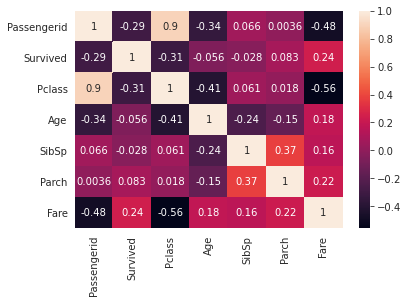

In [35]:
sns.heatmap(titanic.corr(), annot=True)

<AxesSubplot:xlabel='Survived', ylabel='count'>

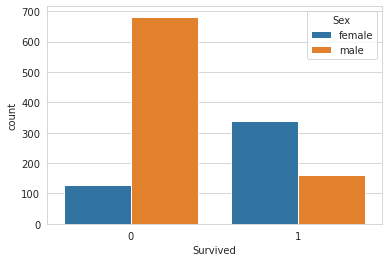

In [36]:
sns.set_style('whitegrid')
sns.countplot(x='Survived', hue = 'Sex', data = titanic)

<AxesSubplot:xlabel='Survived', ylabel='count'>

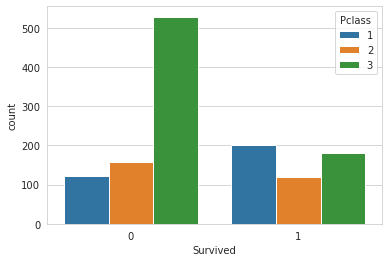

In [37]:
sns.countplot(x='Survived', hue = 'Pclass', data = titanic)

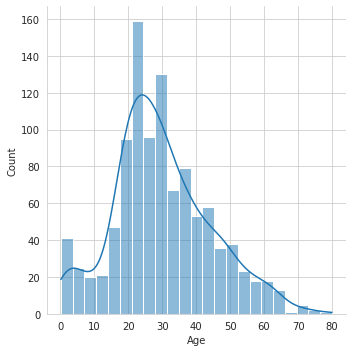

In [38]:
sns.displot(titanic.Age.dropna(), kde=True)

<AxesSubplot:xlabel='SibSp', ylabel='count'>

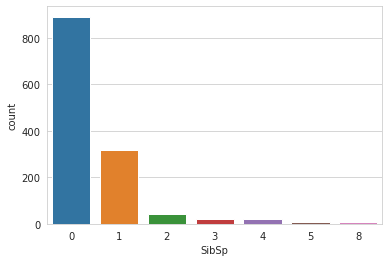

In [39]:
sns.countplot(x='SibSp', data=titanic)

## Handling missing values

In [40]:
titanic.isna().sum()

Passengerid       0
Survived          0
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

Text(0.5, 1.0, 'Heatmap of missing values')

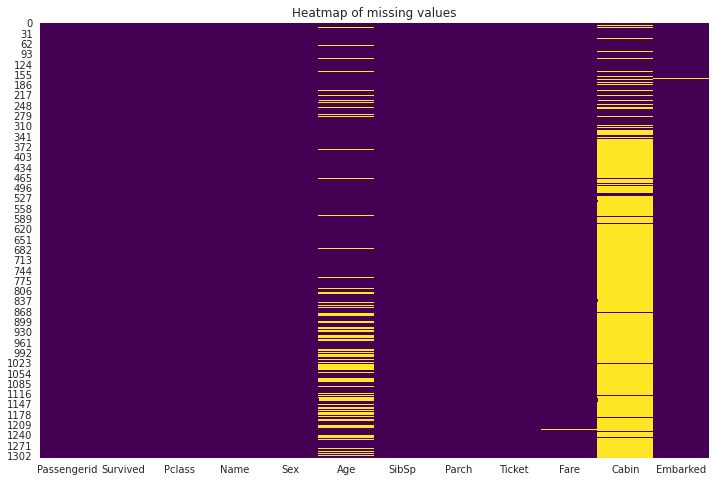

In [41]:
plt.figure(figsize=(12,8))
sns.heatmap(titanic.isnull(), cbar=False, cmap='viridis').set_title('Heatmap of missing values')

### Dropping the cabin-column

In [42]:
titanic.drop(columns=['Cabin'], inplace = True)

### Imputing missing values for age and fare

In [43]:
titanic.corr().loc[['Age', 'Fare']]

,Passengerid,Survived,Pclass,Age,SibSp,Parch,Fare
Age,-0.343888,-0.055513,-0.408106,1.000000,-0.243699,-0.150917,0.178739
Fare,-0.481215,0.244265,-0.558629,0.178739,0.160238,0.221539,1.000000


In [44]:
titanic.Age.fillna(titanic.groupby(['Pclass']).Age.transform('mean'), inplace = True)

In [45]:
titanic.Fare.fillna(titanic.groupby(['Pclass']).Fare.transform('mean'), inplace = True)

### Handling missing values for embarked-column by using the modal value

In [46]:
titanic.Embarked.value_counts()

S    914
C    270
Q    123
Name: Embarked, dtype: int64

In [47]:
titanic.loc[titanic.Embarked.isna(), 'Embarked'] = 'S'

In [48]:
titanic.isna().sum()

Passengerid    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

## Feature engineering

### Creating a feature that will replace Sibsp and Parch, indicating if a passenger is travelling with any other family members.

In [49]:
titanic['TravellingAlone'] = (titanic.SibSp + titanic.Parch + 1).apply(lambda size: 0 if size > 1 else 1)

In [50]:
titanic[['Survived', 'TravellingAlone']].groupby(['TravellingAlone'], as_index=False).mean()

,TravellingAlone,Survived
0,0,0.502890
1,1,0.302532


### Creating dummy variables for Pclass, Sex and Embarked

In [51]:
dummies = pd.get_dummies(titanic[['Pclass', 'Sex', 'Embarked']], drop_first=True)

## Splitting data into train and test sets

In [52]:
from sklearn.model_selection import train_test_split

In [53]:
X = pd.concat([dummies, titanic[['Age', 'Fare', 'TravellingAlone']]], axis=1).values
y = titanic['Survived'].values.reshape(-1,1)

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [55]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((916, 7), (393, 7), (916, 1), (393, 1))

In [56]:
from logistic_regression import LogisticRegression

In [57]:
model = LogisticRegression()

The cost at iteration 0 is 0.6491156797020754
The cost at iteration 1000 is 0.5719670624680706
The cost at iteration 2000 is 0.5530951117772474
The cost at iteration 3000 is 0.5399271590717643
The cost at iteration 4000 is 0.530013276601463
The cost at iteration 5000 is 0.5224310534167084
The cost at iteration 6000 is 0.5165551277756145
The cost at iteration 7000 is 0.5119369456307535
The cost at iteration 8000 is 0.5082529997231733
The cost at iteration 9000 is 0.5052688703385904
The cost at iteration 10000 is 0.5028136419836153
The cost at iteration 11000 is 0.5007618245615058
The cost at iteration 12000 is 0.49902059945149563
The cost at iteration 13000 is 0.49752079949077016
The cost at iteration 14000 is 0.4962104984857377
The cost at iteration 15000 is 0.4950504273045473
The cost at iteration 16000 is 0.49401067401257176
The cost at iteration 17000 is 0.49306829188980256
The cost at iteration 18000 is 0.4922055535682009
The cost at iteration 19000 is 0.4914086681481182
The cost a

The cost at iteration 165000 is 0.46727645402380114
The cost at iteration 166000 is 0.467257398527726
The cost at iteration 167000 is 0.46723875783834923
The cost at iteration 168000 is 0.46722052270563275
The cost at iteration 169000 is 0.46720268409230914
The cost at iteration 170000 is 0.4671852331688022
The cost at iteration 171000 is 0.4671681613082746
The cost at iteration 172000 is 0.46715146008179825
The cost at iteration 173000 is 0.46713512125364426
The cost at iteration 174000 is 0.4671191367766892
The cost at iteration 175000 is 0.4671034987879357
The cost at iteration 176000 is 0.46708819960414344
The cost at iteration 177000 is 0.46707323171756765
The cost at iteration 178000 is 0.46705858779180354
The cost at iteration 179000 is 0.4670442606577326
The cost at iteration 180000 is 0.4670302433095686
The cost at iteration 181000 is 0.4670165289010014
The cost at iteration 182000 is 0.46700311074143486
The cost at iteration 183000 is 0.466989982292318
The cost at iteration 1

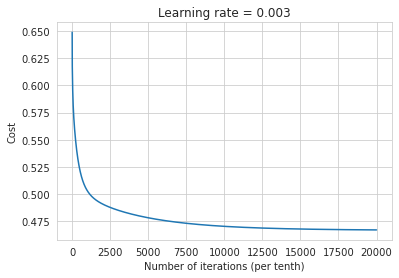

In [58]:
model.fit(X_train, y_train, num_iterations=200000, learning_rate=0.003)

In [59]:
predictions = model.predict(X_test)

In [60]:
log_model_accuracy = model.score(y_test, predictions)
log_model_accuracy

80.6615776081425

## Comparing my model with a simple model that predicts survival for  all females and non-survival for all males

In [61]:
base_rate_sex_model = titanic.Sex.map({'male':0, 'female':1})

In [62]:
from sklearn.metrics import accuracy_score

In [63]:
base_model_accuracy = accuracy_score(titanic.Survived, base_rate_sex_model)
base_model_accuracy

0.7799847211611918

In [79]:
log_model_accuracy > base_model_accuracy

True